# Programming Exercise 3: Multi-Class Classification and Neural Networks

## Introduction
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits. Before starting the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

The functions you will complete are: 

- lrCostFunction.m - Logistic regression cost function
- oneVsAll.m - Train a one-vs-all multi-class classifier
- predictOneVsAll.m - Predict using a one-vs-all multi-class classifier
- predict.m - Neural network prediction function

**Instructions**:

For each function, we have provided starter code for you. You will find a description of the problems followed by a cell which contains some code. You will have to write your own code in these cells to complete the four functions mentioned above. Once you run the cells, your output would be displayed. If it matches the expected output, then you should continue with the next part of the exercise, else, you would have to try again. 

Please read the [Notebook FAQ](https://www.coursera.org/learn/machine-learning/supplement/S9fb6/jupyter-notebook-faq) to get familiar with the Jupyter environment and the commands. We also highly recommend going to your workspace to explore the files you will be working with before starting the exercise.

To go to the workspace: press on File ==> Open.

### NOTE:
You will find cells which contain the comment % GRADED FUNCTION: functionName. Do not edit that comment. Those cells will be used to grade your assignment. Each block of code with that comment should only have the function. 


#### After submitting your assignment, you can [check your grades here](https://www.coursera.org/learn/machine-learning/programming/fF72z/multi-classification-and-nn). 


## Multi-Class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.
In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.

### Data Set

You are given a data set in **ex3data1.mat** that contains 5000 training examples of handwritten digits$^1$. The **.mat** format means that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into your program by using the load command. After loading, matrices of the correct dimensions and values will appear in your program’s memory. The matrix will already be named, so you do not need to assign names to them. Run the cell below to initialize your matrix and some other useful variables.

**Note:** Trying to print X and y might kill your kernel.


In [3]:
warning('off'); addpath('../readonly/Assignment3/');
load('ex3data1.mat');     % X and y are arrays where your training data is stores
input_layer_size  = 400;  % 20x20 Input Images of Digits
num_labels = 10;          % 10 labels, from 1 to 10   
m = size(X, 1);           % number of rows

whos;                     % Check out your new variables

Variables in the current scope:

   Attr Name                  Size                     Bytes  Class
   ==== ====                  ====                     =====  ===== 
        X                  5000x400                 16000000  double
   c    ans                   1x1                         16  double
        input_layer_size      1x1                          8  double
        lambda                1x1                          8  double
        m                     1x1                          8  double
        num_labels            1x1                          8  double
        temp_theta            5x1                         40  double
        temp_y                5x1                         40  double
        y                  5000x1                      40000  double

Total is 2005015 elements using 16040128 bytes



There are 5000 training examples in **ex3data1.mat**, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.


$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)})^T --- \\
--- (x^{(2)})^T --- \\
\vdots \\ 
--- (x^{(m)})^T --- 
\end{array}\right)$$ 



The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.

### Visualizing the Data

You will begin by visualizing a subset of the training set. In the cell below, the code randomly selects selects 100 rows from X and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the displayData function, and you are encouraged to examine the code to see how it works. After you run this step, you should see the image below. 

<img src="../readonly/Assignment3/figure 1.png" width="450" height="450">

Run the cell below to display the data. 

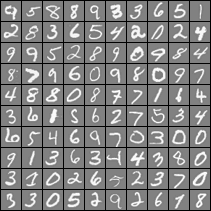

In [2]:
rand_indices = randperm(m);          % Randomly select 100 data points to display
sel = X(rand_indices(1:100), :);     
displayData(sel);                    

## Vectorizing Logisitic Regression

In this section, you will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point for this exercise.

### Vectorizing the Cost function

We will begin by writing a vectorized version of the cost function.
Recall that in (unregularized) logistic regression, the cost function is
$$J(\theta)=\frac{{1}}{m}\sum_{i=1}^{m}\left[
 -y^{(i)}\log(h_{\theta}(x^{(i)}))-
 (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))\right]\tag{1} $$

To compute each element in the summation, we have to compute
$h_\theta(x^{(i)})$ for every example $i$, where
$h_\theta(x^{(i)}) = g(\theta^Tx^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$
is the sigmoid function. It turns out that we can compute this quickly
for all our examples by using matrix multiplication. Let us define $X$
and $\theta$ as 


$$X = 
\left(\begin{array}{cc} 
---(x^{(1)})^T--- \\
---(x^{(2)})^T--- \\
\vdots \\ 
---(x^{(m)})^T--- 
\end{array}\right) \; \; \; and \; \; \; \theta = \left(\begin{array}{cc} 
 \theta_0 \\
\theta_1 \\
\vdots \\ 
\theta_M 
\end{array}\right) $$ 

Then by computing the matrix product $X\theta$, we have
$$X = 
\left(\begin{array}{cc} 
---(x^{(1)})^T\theta--- \\
---(x^{(2)})^T\theta--- \\
\vdots \\ 
---(x^{(m)})^T\theta--- 
\end{array}\right) = 
\left(\begin{array}{cc} 
---\theta^T(x^{(1)})--- \\
---\theta^T(x^{(2)})--- \\
\vdots \\ 
---\theta^T(x^{(m)})--- 
\end{array}\right)
$$


 In the last equality, we used the fact that $a^Tb = b^Ta$ if
$a$ and $b$ are vectors. This allows us to compute the products
$\theta^Tx^{(i)}$ for all our examples $i$ in one line of code.

Your job is to write the unregularized cost function in the cell below.
Your implementation should use the strategy we
presented above to calculate $\theta^Tx^{(i)}$. You should also use a
vectorized approach for the rest of the cost function. A fully
vectorized version of lrCostFunction should not contain any
loops.

**Hint:** You might want to use the element-wise multiplication operation
(.*) and the sum operation (sum) when writing this
function.

### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost
is a vector where the $j^\mathrm{th}$ element is defined as
$$ \frac{\partial J}{\partial\theta_j} = \frac{1}{m}  \sum_{i=1}^m \left( (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)}\right).\tag{2}$$

To vectorize this operation over the dataset, we start by writing out
all the partial derivatives explicitly for all $\theta_j$,

$$\begin{bmatrix}
\frac{\partial J}{\partial\theta_0} \\
\frac{\partial J}{\partial\theta_1} \\
\frac{\partial J}{\partial\theta_2} \\
\vdots \\
\frac{\partial J}{\partial\theta_n} 
\end{bmatrix}
= \frac{1}{m} \begin{bmatrix}
 \sum_{i=1}^m \left( (h_{\theta}(x^{(i)}) - y^{(i)}) x_0^{(i)} \right) \\
 \sum_{i=1}^m \left( (h_{\theta}(x^{(i)}) - y^{(i)}) x_1^{(i)}\right) \\
 \sum_{i=1}^m \left( (h_{\theta}(x^{(i)}) - y^{(i)}) x_2^{(i)}\right) \\
 \vdots \nonumber \\ 
 \sum_{i=1}^m \left( (h_{\theta}(x^{(i)}) - y^{(i)}) x_n^{(i)}\right) 
\end{bmatrix}
$$

$$ = \frac{1}{m} \sum_{i=1}^m \left( (h_{\theta}(x^{(i)}) - y^{(i)}) x^{(i)} \right)$$
$$ = \frac{1}{m} X^T(h_{\theta}(x) - y) \: \: \: \: \: \: \: \: \: \: \: \:\tag{3}$$                             

where:
$$h_{\theta}(x) - y = \begin{bmatrix} 
h_{\theta}(x^{(1)}) - y^{(1)}  \\
h_{\theta}(x^{(2)}) - y^{(2)}  \\
\vdots \\ 
h_{\theta}(x^{(1)}) - y^{(m)}  \\
\end{bmatrix}
$$

Note that $x^{(i)}$ is a vector, while
$ (h_{\theta}(x^{(i)}) - y^{(i)})$ is a scalar (single number). To
understand the last step of the derivation, let
$\beta_i = (h_{\theta}(x^{(i)}) - y^{(i)})$ and observe that:

$$\sum_i \beta_i x^{(i)} = \begin{bmatrix}
| & | & & |  \\
x^{(1)} & x^{(2)} & \dots & x^{(m)}  \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1  \\
\beta_2  \\
\vdots \\ 
\beta_m  \\
\end{bmatrix} = X^T \beta,$$

where the values $\beta_i = (h_{\theta}(x^{(i)}) - y^{(i)})$.

The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. You should now implement Equation 1 to compute the correct vectorized gradient. Once you are done, complete the function lrCostFunction above by implementing the gradient.

**Debugging Tip:** Vectorizing code can sometimes be tricky. One com- mon strategy for debugging is to print out the sizes of the matrices you are working with using the size function. For example, given a data matrix $X$ of size 100 × 20 (100 examples, 20 features) and θ, a vector with dimensions 20×1, you can observe that $X\theta$ is a valid multiplication operation, while $X\theta$ is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.

***Implementation***

J = lrCostFunction(theta, X, y, lambda) computes the cost of using theta as the parameter for regularized logistic regression and the gradient of the cost w.r.t. to the parameters. 

You need to compute the cost of a particular choice of theta. You should set J to the cost we defined for you in **equation 1**. Compute the partial derivatives and set grad to the partial derivatives of the cost w.r.t. each parameter in theta. This means, you will have to set grad to **equation 3** to get the vectorized version. We have also provided you with the sigmoid function. To compute h, for example, you could use: h = sigmoid(X*theta). Each row of the resulting matrix will contain the value of the prediction for that example. You can make use of this to vectorize the cost function and the gradient computations. 

In [25]:
% GRADED FUNCTION: lrCostFunction
function [J, grad] = lrCostFunction(theta, X, y, lambda)

m = length(y);                        % number of training examples
J = 0;                                % return the following variables correctly 
grad = zeros(size(theta));            % initializing the gradient

% ====================== YOUR CODE HERE ======================
h = sigmoid(X * theta);
J = -1/m * (y'*log(h) + (1-y)'*log(1-h)) + lambda/(2*m) * (theta(2:end)'*theta(2:end));
grad(1,1) = 1/m * (X(:,1)'*(h-y));
grad(2:end) = 1/m *(X(:,2:end)'*(h-y)) + (lambda/m) *theta(2:end);
% ============================================================

grad = grad(:);

end

In [27]:
% Initialize random variables to check your implementation
lambda = 0.9;                           % Set this to 0.9 to see if your output matches ours for the regularized part.
temp_X = X(30:34,130:134);                                   % Get a random X matrix
temp_theta = [3,-5,13,-.4, 0.3]';                            % Initialize theta
temp_y = [1,2,-3,4,-5]';                                     % Initialize y  
                                                            
% Compute Cost and gradient
[J, grad] = lrCostFunction(temp_theta, temp_X, temp_y, lambda);

% Check your results! 
% We only printed the first few grad numbers to avoid printing the entire list
J 
grad(1:5)

J =  29.404
ans =

   1.22153
   0.14953
   3.36328
   1.13201
   1.41260



**Expected Output**:

Note the results might not make sense, and this is just to make sure that your implementation is correct. 

Non regularized function (lambda = 0): 

$$J = 11.922 \;\;\;\;\;\;\;\;\;\;\; \;\;\;\;\;\;\;\;\;   grad(1:5) = \left(\begin{array}{cc} 
   1.2215 \\
   1.0495 \\
   1.0233 \\
   1.2040 \\
   1.3586 \\ \end{array}\right)$$
   
Regularized function (lambda = 0.9): 

$$J = 29.404 \;\;\;\;\;\;\;\;\;\;\; \;\;\;\;\;\;\;\;\;   grad(1:5) = \left(\begin{array}{cc} 
   1.22153 \\
   0.14953 \\
   3.36328 \\
   1.13201 \\
   1.41260 \\ \end{array}\right)$$





### Vectorizing Regularized Logistic Regression


After you have implemented vectorization for logistic regression, you
will now add regularization to the cost function. Recall that for
regularized logistic regression, the cost function is defined as
$$J(\theta)=\frac{{1}}{m}\sum_{i=1}^{m}\left[
 -y^{(i)}\log(h_{\theta}(x^{(i)}))-
 (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))\right] + 
 \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2.\tag{4}$$

Note that you should *not* be regularizing $\theta_0$ which is used for
the bias term.

Correspondingly, the partial derivative of regularized logistic
regression cost for $\theta_j$ is defined as

$$\frac{\partial J(\theta)}{\partial\theta_0} = \frac{1}{m}  \sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)} \quad\quad\quad\quad\quad\quad \mbox{for $j = 0$}\tag{5}$$

$$\frac{\partial J(\theta)}{\partial\theta_j} = \left( \frac{1}{m}  \sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j  \quad\, \mbox{for $j \geq 1$}\tag{6}$$

Now modify your code in lrCostFunction to account for
regularization. Once again, you should not put any loops into your
code.

**Implementation**: 

When implementing the vectorization for regularized logistic
regression, you might often want to only sum and update certain elements of $\theta$.
In Octave/MATLAB, you can index into the matrices to access and update only certain elements.
For example, A(:, 3:5) = B(:, 1:3) will replaces the columns 3 to 5 of A with 
the columns 1 to 3 from B. One special keyword you can use in indexing is the **end**
keyword. This allows us to select columns (or rows) until the end of the matrix.
For example, grad(2:end) will only return the $2^{nd}$ to last elements.

Thus, you could use this together with the **sum** and .^ operations to compute the
sum of only the elements you are interested in ($e.g.,sum(A(2:end).^2 ))$. 

When computing the gradient of the regularized cost function, there're many possible vectorized solutions. You should keep your grad as it is and add the regularization term to all its elements except for grad(1). You should also add to your cost the regularization term. 

One-vs-all Classification
-------------------------

In this part of the exercise, you will implement one-vs-all
classification by training multiple regularized logistic regression
classifiers, one for each of the $K$ classes in our dataset (Figure 1). In the handwritten digits dataset, $K=10$, but your code should work for any value of $K$.

You will now complete the oneVsAll function below to train one
classifier for each class. In particular, your code should return all
the classifier parameters in a matrix
$\Theta \in \mathbb{R}^{K\times(N+1)}$ , where each row of $\Theta$
corresponds to the learned logistic regression parameters for one class.
You can do this with a forloop from $1$ to $K$, training each
classifier independently.

Note that the **y** argument to this function is a vector of labels
from 1 to 10, where we have mapped the digit “0” to the label 10 (to
avoid confusions with indexing).

When training the classifier for class $k \in \{1,...,K\}$, you will
want a $m$-dimensional vector of labels $y$, where $y_j \in {0, 1}$
indicates whether the $j$-th training instance belongs to class $k$
($y_j = 1$), or if it belongs to a different class ($y_j = 0$). You may
find logical arrays helpful for this task.

**Octave/MATLAB Tip:** Logical arrays in Octave/MATLAB are arrays which
contain binary (0 or 1) elements. In Octave/MATLAB, evaluating the
expression $a == b$ for a vector $a$ (of size $m\times1$) and
scalar $b$ will return a vector of the same size as $a$ with
ones at positions where the elements of a are equal to b and
zeroes where they are different. To see how this works for yourself, run the cell below.

In [28]:
a = 1:10 % Create a and b 
b = 3
a == b    % You should try different values of b here

a =

    1    2    3    4    5    6    7    8    9   10

b =  3
ans =

   0   0   1   0   0   0   0   0   0   0



Furthermore, you will be using **fmincg** for this exercise (instead of **fminunc**). **fmincg** works similarly to **fminunc**, but is more more efficient for dealing with
a large number of parameters.
After you have correctly completed the code for **oneVsAll**, we will use your oneVsAll function to train a multi-class classifier.

** Instructions ** 

[all_theta] = oneVsAll(X, y, num_labels, lambda) trains num_labels logisitc regression classifiers and returns each of these classifiers in a matrix all_theta, where the $i^{th}$ row of all_theta corresponds to the classifier for label i.

You should complete the function below to train num_labels logistic regression classifiers with regularization parameter lambda.

**Hints**: theta(:) will return a column vector. You can use y == c to obtain a vector of 1's and 0's that tell you whether the ground truth is true/false for this class. For this assignment, we recommend using fmincg to optimize the cost function. It is okay to use a for-loop (for c = 1:num_labels) to loop over the different classes. fmincg works similarly to fminunc, but is more efficient when we are dealing with large number of parameters.

* initial_theta = zeros(n + 1, 1); ==> (set initial theta)

* options = optimset('GradObj', 'on', 'MaxIter', 50); ==> (Set options for fminunc)

Run fmincg to obtain the optimal theta, this function will return theta and the cost:

* [theta] = fmincg (@(t)(lrCostFunction(t, X, (y == c), lambda)),initial_theta, options);
                 

In [77]:
% GRADED FUNCTION: oneVsAll
function [all_theta] = oneVsAll(X, y, num_labels, lambda)

m = size(X, 1);                                      % Some useful variables
n = size(X, 2);
all_theta = zeros(num_labels, n + 1);                % You need to return the following variable correctly
X = [ones(m, 1) X];                                  % Add ones to the X data matrix

% ====================== YOUR CODE HERE ======================
for i = 1:num_labels
    initial_theta = zeros(n+1, 1);
    options = optimset('GradObj', 'on', 'MaxIter', 50);
    [theta] = fmincg (@(t)(lrCostFunction(t, X, (y == i), lambda)),initial_theta, options);
    all_theta(i,:) = theta(:);
end
% =============================================================
end

Now we will check whether your classfication works. After this, you will implement one-vs-all classification for the handwritten digit dataset.

**Note:** This takes about a minute to run. 


In [78]:
lambda = 0.1;
[all_theta] = oneVsAll(X, y, num_labels, lambda);

Iteration    50 | Cost: 1.370520e-02
Iteration    50 | Cost: 5.725253e-02
Iteration    50 | Cost: 6.407287e-02
Iteration    50 | Cost: 3.663827e-02
Iteration    50 | Cost: 6.182303e-02
Iteration    50 | Cost: 2.172996e-02
Iteration    50 | Cost: 3.578803e-02
Iteration    50 | Cost: 8.586417e-02
Iteration    50 | Cost: 7.958069e-02
Iteration    50 | Cost: 1.003850e-02


### One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict
the digit contained in a given image. For each input, you should compute
the “probability” that it belongs to each class using the trained
logistic regression classifiers. Your one-vs-all prediction function
will pick the class for which the corresponding logistic regression
classifier outputs the highest probability and return the class label
(1, 2,..., or $K$) as the prediction for the input example.

You should now complete the code in the predictOneVsAll function below in order to use the
one-vs-all classifier to make predictions. Once you are done, we will call your **predictOneVsAll**
function using the learned value of $\Theta$. 

**Instructions:**

Predict the label for a trained one-vs-all classifier. The labels are in the range 1..K, where K = size(all_theta, 1). 

p = predictOneVsAll(all_theta, X) will return a vector of predictions for each example in the matrix X. Note that X contains the examples in rows. all_theta is a matrix where the i-th row is a trained logistic regression theta vector for the i-th class. You should set p to a vector of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2 for 4 examples) 

Complete the following code to make predictions using your learned logistic regression parameters (one-vs-all). You should set p to a vector of predictions (from 1 to num_labels).

This code can be done all vectorized using the max function. In particular, the max function can also return the index of the max element, for more information see 'help max'. If your examples are in rows, then, you can use max(A, [], 2) to obtain the max for each row.


In [79]:
% GRADED FUNCTION: predictOneVsAll
function p = predictOneVsAll(all_theta, X)

m = size(X, 1);                                 % Declaring some useful variables
num_labels = size(all_theta, 1);

p = zeros(m, 1);                       % Return the following variables correctly 
X = [ones(m, 1) X];                             % Add ones to the X data matrix

% ====================== YOUR CODE HERE ======================
h = sigmoid(X * all_theta');
[x, i] = max(h,[], 2);
p = i;
% ============================================================
end

In [80]:
whos
pred = predictOneVsAll(all_theta, X);
Accuracy =  mean(double(pred == y)) * 100

Variables in the current scope:

   Attr Name                  Size                     Bytes  Class
   ==== ====                  ====                     =====  ===== 
        Accuracy              1x1                          8  double
        J                     1x1                          8  double
        X                  5000x400                 16000000  double
        a                     1x10                        24  double
        all_theta            10x401                    32080  double
        ans                   1x401                     3208  double
        b                     1x1                          8  double
        grad                  5x1                         40  double
        input_layer_size      1x1                          8  double
        lambda                1x1                          8  double
        m                     1x1                          8  double
        num_labels            1x1                          8  double
  

**Expected Output:** 

You should see that the training set accuracy is approximately 94% [i.e., it classifies 94% of the
examples in the training set correctly.]

Neural Networks
===============

In the previous part of this exercise, you implemented multi-class
logistic regression to recognize handwritten digits. However, logistic
regression cannot form more complex hypotheses as it is only a linear
classifier.

In this part of the exercise, you will implement a neural network to
recognize handwritten digits using the same training set as before. The
neural network will be able to represent complex models that form
non-linear hypotheses. For this week, you will be using parameters from
a neural network that we have already trained. Your goal is to implement
the feedforward propagation algorithm to use our weights for prediction.
In the next exercise, you will write the backpropagation algorithm
for learning the neural network parameters.





Model representation
--------------------

Our neural network is shown in Figure 2. It has 3
layers – an input layer, a hidden layer and an output layer. Recall that
our inputs are pixel values of digit images. Since the images are of
size $20\times20$, this gives us $400$ input layer units (excluding the
extra bias unit which always outputs $+1$). As before, the training data
will be loaded into the variables $X$ and $y$.

<img src="../readonly/Assignment3/figure 2.png" width="450" height="450">

You have been provided with a set of network parameters
($\Theta^{(1)},\Theta^{(2)}$) already trained by us. These are stored in the file
**ex3weights.mat** and will be loaded by the script in the cell below into
$Theta1$ and $Theta2$. The parameters have dimensions that are
sized for a neural network with $25$ units in the second layer and $10$
output units (corresponding to the 10 digit classes).

You could add more features (such as polynomial features) to logistic regression, but that can be very expensive to train. Hence, we start the exercise by first loading and visualizing the dataset. You will be working with a dataset that contains handwritten digits.

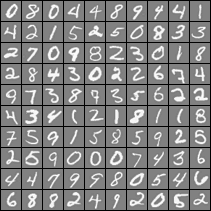

In [81]:
load('ex3data1.mat');           % loading the data
load('ex3weights.mat');
m = size(X, 1);                 % number of rows

sel = randperm(size(X, 1));     % randomly select 100 data points to display
sel = sel(1:100);

displayData(X(sel, :));         % display the data 

## Feedforward Propagation and Prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in predict.m to return the neural network’s prediction.
You should implement the feedforward computation that computes $h_{\theta}(x_{(i)})$ for every example i and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $h_\theta(x))_k$.

**Implementation Note:** The matrix X contains the examples in rows. When you complete the code below, you will need to add the column of 1’s to the matrix. The matrices Theta1 and Theta2 contain the parameters for each unit in rows. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. In Octave/MATLAB, when you compute $z^{(2)} = \Theta^{(1)}a^{(1)}$, be sure that you index $X$ correctly so that you get $a^{(l)}$ as a column vector.

p = predict(Theta1, Theta2, X) outputs the predicted label of X given the trained weights of a neural network (Theta1, Theta2). Complete the code below to make predictions using your learned neural network. You should set p to a vector containing labels between 1 to num_labels. Remember that the sigmoid function is available in your workspace, so you could just use $sigmoid(X * theta')$ to get your h. Also don't forget to add the bias term; a column of ones to your matrix before multiplying with Theta. The max function might come in useful. In particular, the max function can also return the index of the max element, for more information see 'help max'. If your examples are in rows, then, you can use max(A, [ ], 2) to obtain the max for each row.


In [93]:
% GRADED FUNCTION: predict
function p = predict(Theta1, Theta2, X)

% X is 5000 by 400
% Theta1 is 25 by 401
% Theta2 is 10 by 26

m = size(X, 1);                                % Useful values
num_labels = size(Theta2, 1);
p = zeros(size(X, 1), 1);                      % Return the following variable correctly 

% ====================== YOUR CODE HERE ======================
X = [ones(m,1) X];
a2 = sigmoid(X * Theta1');
a2 = [ones(size(a2,1),1) a2];

h = sigmoid(a2 * Theta2');
[x, i] = max(h, [], 2);
p = i;

% ============================================================

end

In [94]:
% Now we will call your predict function using the 
% loaded set of parameters for Theta1 and Theta2. 
pred = predict(Theta1, Theta2, X);         % predicting the output
Accuracy = mean(double(pred == y)) * 100   % Accuracy 

Accuracy =  97.520


** Expected Output**

You should see that the accuracy is about 97.5%. 


Displaying Example Image

Neural Network Prediction: 3 (digit 3)


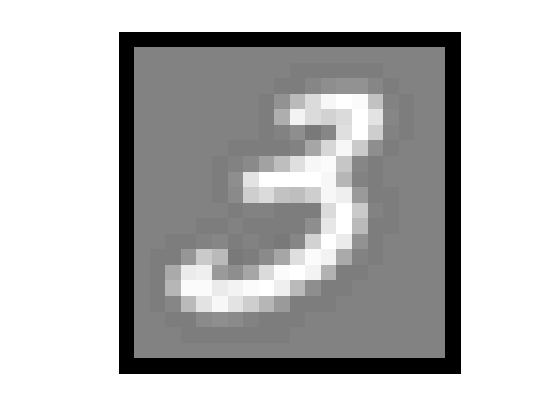

In [95]:
%  To give you an idea of the network's output, you can also run
%  through the examples one at the a time to see what it is predicting.

%  Keep re-running this cell to see different numbers 
k = 10000;  
%  Randomly permute examples one at a time
rp = randperm(k/2);

% Display 
fprintf('\nDisplaying Example Image\n');
displayData(X(rp(k/2), :));

pred = predict(Theta1, Theta2, X(rp(k/2),:));
fprintf('\nNeural Network Prediction: %d (digit %d)\n', pred, mod(pred, k/2));

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>